In [1]:
!pip install statsmodels

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score



In [3]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()
 
table_name = '"FACT_CUSTOMER_ORDERS"'
 
sf_df = my_session.sql("select * from {}".format(table_name))
df = sf_df.to_pandas()

In [4]:
data = df[['PRODUCT_ID','ORDER_DATE','ORDER_QTY']]

In [5]:
data['ORDER_DATE']=pd.to_datetime(data['ORDER_DATE'])

In [6]:
data_grouped = data.groupby(['PRODUCT_ID',data['ORDER_DATE'].dt.to_period('M')]).agg(Total_Order_Qty=('ORDER_QTY','sum')).reset_index()

In [7]:
data_grouped['ORDER_MONTH']=data_grouped['ORDER_DATE'].dt.to_timestamp()

In [9]:
data_grouped = data_grouped[['PRODUCT_ID','ORDER_MONTH','Total_Order_Qty']]

In [10]:
data_grouped

,PRODUCT_ID,ORDER_MONTH,Total_Order_Qty
0,Product_001,2019-01-01,148400
1,Product_001,2019-02-01,146650
2,Product_001,2019-03-01,133150
3,Product_001,2019-04-01,153600
4,Product_001,2019-05-01,154650
...,...,...,...
2987,Product_100,2024-04-01,30200
2988,Product_100,2024-05-01,27850
2989,Product_100,2024-06-01,33200
2990,Product_100,2024-07-01,33300


In [11]:
data_grouped = data_grouped.set_index('ORDER_MONTH')

In [12]:
data_grouped

,PRODUCT_ID,Total_Order_Qty
ORDER_MONTH,,
2019-01-01,Product_001,148400
2019-02-01,Product_001,146650
2019-03-01,Product_001,133150
2019-04-01,Product_001,153600
2019-05-01,Product_001,154650
...,...,...
2024-04-01,Product_100,30200
2024-05-01,Product_100,27850
2024-06-01,Product_100,33200


In [17]:
# Group data by 'product_id'
PID_grouped_data = data_grouped.groupby('PRODUCT_ID')

In [47]:
# Initialize an empty DataFrame for forecast results
test_results = pd.DataFrame(columns=['PRODUCT_ID','ORDER_MONTH', 'test_forecast_orders','rse', 'rmse','r2_score'])

In [48]:
forecast_results = pd.DataFrame(columns=['PRODUCT_ID','ORDER_MONTH', 'forecast_order_qty'])

In [49]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 40 must be < 27.

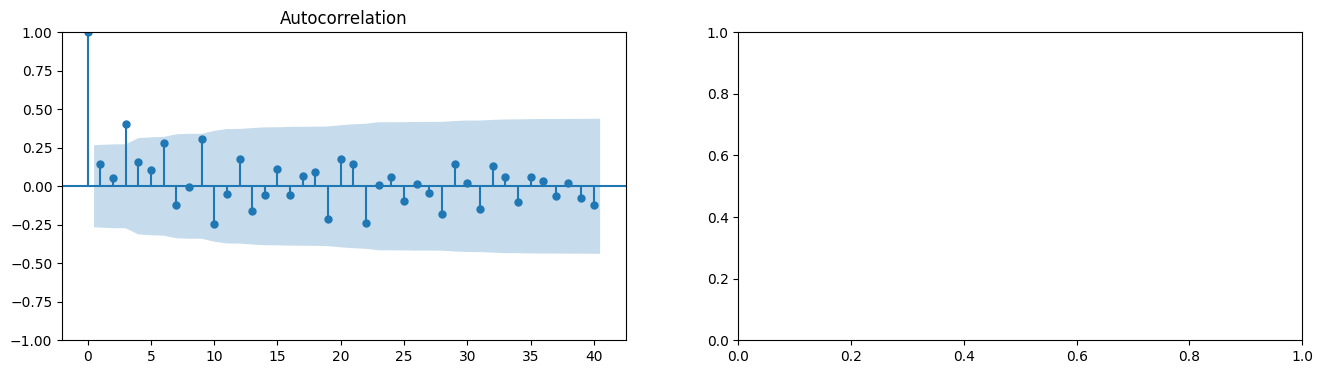

In [51]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming PID_grouped_data is already defined
for product_id, group in PID_grouped_data:
    # Sort data by order date
    group.sort_index(inplace=True)

    # Split data into train and test sets (80% train, 20% test)
    train_size = int(0.8 * len(group))
    train_data, test_data = group.iloc[:train_size], group.iloc[train_size:]

    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(train_data['Total_Order_Qty'], lags=40, ax=axes[0])
    plot_pacf(train_data['Total_Order_Qty'], lags=40, ax=axes[1])
    plt.show()

    # Based on the plots, set the p, d, q values
    p = 1  # Example value, adjust based on PACF plot
    d = 1  # Example value, adjust based on stationarity
    q = 1  # Example value, adjust based on ACF plot

    # Create SARIMAX model
    model = SARIMAX(train_data['Total_Order_Qty'], order=(p, d, q), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    
    # Forecast the next period
    test_model = model_fit.get_forecast(steps=len(test_data))
    test_df = test_model.predicted_mean

    # Evaluate the model
    rse = np.sqrt(((test_df - test_data['Total_Order_Qty']) ** 2).sum() / (test_data.shape[0] - len(model_fit.params)))
    rmse = np.sqrt(mean_squared_error(test_data['Total_Order_Qty'], test_df))
    r2 = r2_score(test_data['Total_Order_Qty'], test_df)

   # print(f'{product_id:},{r2}')
    
    new_row = {
        'PRODUCT_ID': product_id,
        'ORDER_MONTH': test_df.index,
        'test_forecast_orders': test_df,
        'rse': rse,
        'rmse': rmse,
        'r2_score': r2
    }
    
    df_new = pd.DataFrame(new_row)
    df_new.set_index('ORDER_MONTH', inplace=True)
    
    test_results = pd.concat([test_results, df_new], ignore_index=True)
    
    # Forecast future values
    forecast = model_fit.get_forecast(steps=25)
    forecast_df = forecast.predicted_mean
    
    new_row2 = {
        'PRODUCT_ID': product_id,
        'ORDER_MONTH': forecast_df.index,
        'forecast_order_qty': forecast_df,
    }
    
    df_new2 = pd.DataFrame(new_row2)
    df_new2.set_index('ORDER_MONTH', inplace=True)
    
    forecast_results = pd.concat([forecast_results, df_new2], ignore_index=True)


In [46]:
for product_id, group in PID_grouped_data:
    # Sort data by order date
    group.sort_index(inplace=True)

    #print(f'{group}')
    
    # Split data into train and test sets (80% train, 20% test)
    train_size = int(0.8 * len(group))
    train_data, test_data = group.iloc[:train_size], group.iloc[train_size:]

    #print(f'{train_data.index}')
    
    # Create SARIMAX model
    model = SARIMAX(train_data['Total_Order_Qty'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    
    # Forecast the next period
    test_model = model_fit.get_forecast(steps=len(test_data))
    test_df = test_model.predicted_mean

    #print(f'test_df:{test_df.index}')
    
    # Calculate RMSE for order quantity
    #rmse_order_qty = np.sqrt(mean_squared_error(test_data['ORDER_QTY'], forecast_order_qty))
    
    # Evaluate the model
    rse = np.sqrt(((test_df - test_data) ** 2).sum().sum() / (test_data.shape[0] * test_data.shape[1] - len(model_fit.params)))
    rmse = np.sqrt(mean_squared_error(test_data['Total_Order_Qty'], test_df))
    r2 = r2_score(test_data['Total_Order_Qty'], test_df)

    print(f'{product_id:},{r2}')
    date_list = test_df.index.to_list()
    

    
    #print(f"Order_date: {date_list}")    
    new_row = {
        'PRODUCT_ID': product_id,
        'ORDER_MONTH': date_list,
        'test_forecast_orders': test_df,
        'rse': rse,
        'rmse': rmse,
        'r2_score': r2
    }
    
    df_new = pd.DataFrame(new_row)

    df_new.set_index('ORDER_MONTH')
    
    test_results=pd.concat([test_results,df_new],ignore_index=True)
    # Forecast future values
    forecast = model_fit.get_forecast(steps=25)#, steps=n_forecast)
    forecast_df = forecast.predicted_mean
    #print(f'{forecast_df.index}')
    date_list2= forecast_df.index.to_list()
    
    new_row2 = {
        'PRODUCT_ID': product_id,
        'ORDER_MONTH': date_list2,
        'forecast_order_qty': forecast_df,
    }
    
    df_new2 = pd.DataFrame(new_row2)
    
    forecast_results=pd.concat([forecast_results,df_new2],ignore_index=True)

Product_001,-0.05508991816590081
Product_002,0.31073083964011405
Product_003,-0.09163168332321847
Product_004,-1.265111025869456
Product_007,-0.25328509749401595
Product_010,0.4088079761872878
Product_015,0.12231014341278801
Product_016,-0.7607350591819617
Product_019,-0.09487182855742882
Product_023,-0.8512316717011159
Product_047,-0.7017110713753403
Product_057,-0.8106611823223848
Product_059,-2.7008313735500655
Product_060,-4.394536131316959
Product_061,-1.2194535417098207
Product_063,-0.052597364407875435
Product_065,-2.5018417630812606
Product_066,-0.1447691869396781
Product_067,0.03217348559395383
Product_069,0.23264444004197327
Product_070,-0.24636838964142038
Product_071,-0.22438368157256083
Product_072,-0.5756541250483518
Product_074,-0.6214515922772503
Product_075,-1.4099587651636751
Product_076,-0.4092133997875327
Product_077,-0.26476073150778356
Product_078,0.009924700584368673
Product_079,0.28963701464723335
Product_082,-0.8959140869580768
Product_083,-0.05164598055127745


In [33]:
test_results

,PRODUCT_ID,ORDER_MONTH,test_forecast_orders,rse,rmse,r2_score
0,Product_001,2023-07-01,118823.028009,0.0,15697.565379,-0.055090
1,Product_001,2023-08-01,101123.262760,0.0,15697.565379,-0.055090
2,Product_001,2023-09-01,105282.149996,0.0,15697.565379,-0.055090
3,Product_001,2023-10-01,117745.845182,0.0,15697.565379,-0.055090
4,Product_001,2023-11-01,110611.593083,0.0,15697.565379,-0.055090
...,...,...,...,...,...,...
611,Product_100,2024-04-01,18561.642690,0.0,8128.208481,-2.288506
612,Product_100,2024-05-01,21368.799836,0.0,8128.208481,-2.288506
613,Product_100,2024-06-01,24816.242093,0.0,8128.208481,-2.288506
614,Product_100,2024-07-01,21318.819139,0.0,8128.208481,-2.288506


In [34]:
forecast_results

,PRODUCT_ID,ORDER_MONTH,forecast_order_qty
0,Product_001,2023-07-01,118823.028009
1,Product_001,2023-08-01,101123.262760
2,Product_001,2023-09-01,105282.149996
3,Product_001,2023-10-01,117745.845182
4,Product_001,2023-11-01,110611.593083
...,...,...,...
1095,Product_100,2025-03-01,26101.562368
1096,Product_100,2025-04-01,17079.529558
1097,Product_100,2025-05-01,20108.877208
1098,Product_100,2025-06-01,22627.141399


In [42]:
sf_df = my_session.createDataFrame(test_results)
sf_df.write.mode("overwrite").save_as_table("ORDER_FORECAST_TEST")
my_session.table("ORDER_FORECAST_TEST").show()

-------------------------------------------------------------------------------------------------------------------
|"PRODUCT_ID"  |"ORDER_MONTH"        |"test_forecast_orders"  |"rse"  |"rmse"              |"r2_score"            |
-------------------------------------------------------------------------------------------------------------------
|Product_001   |2023-07-01 00:00:00  |118823.0280087485       |0.0    |15697.565379119542  |-0.05508991816590081  |
|Product_001   |2023-08-01 00:00:00  |101123.26275967901      |0.0    |15697.565379119542  |-0.05508991816590081  |
|Product_001   |2023-09-01 00:00:00  |105282.14999635714      |0.0    |15697.565379119542  |-0.05508991816590081  |
|Product_001   |2023-10-01 00:00:00  |117745.8451819192       |0.0    |15697.565379119542  |-0.05508991816590081  |
|Product_001   |2023-11-01 00:00:00  |110611.59308316885      |0.0    |15697.565379119542  |-0.05508991816590081  |
|Product_001   |2023-12-01 00:00:00  |109442.18813553792      |0.0    |1

In [43]:
sf_df = my_session.createDataFrame(forecast_results)
sf_df.write.mode("overwrite").save_as_table("ORDER_FORECAST")
my_session.table("ORDER_FORECAST").show()

-------------------------------------------------------------
|"PRODUCT_ID"  |"ORDER_MONTH"        |"forecast_order_qty"  |
-------------------------------------------------------------
|Product_001   |2023-07-01 00:00:00  |118823.0280087485     |
|Product_001   |2023-08-01 00:00:00  |101123.26275967901    |
|Product_001   |2023-09-01 00:00:00  |105282.14999635714    |
|Product_001   |2023-10-01 00:00:00  |117745.8451819192     |
|Product_001   |2023-11-01 00:00:00  |110611.59308316885    |
|Product_001   |2023-12-01 00:00:00  |109442.18813553792    |
|Product_001   |2024-01-01 00:00:00  |123789.85901559627    |
|Product_001   |2024-02-01 00:00:00  |121702.67368633783    |
|Product_001   |2024-03-01 00:00:00  |126125.91939069977    |
|Product_001   |2024-04-01 00:00:00  |122617.48431518582    |
-------------------------------------------------------------

